In [5]:
from datetime import datetime

print("----------------------------------------------------------------------------")
print(f"Last modified: {datetime.now().strftime("%d %B %Y, %H:%M")}")
print("----------------------------------------------------------------------------")



----------------------------------------------------------------------------
Last modified: 10 September 2025, 15:13
----------------------------------------------------------------------------


# Basic Kinematic Plots

In this section, we’ll examine **basic kinematic distributions** for our processes. Specifically, we’ll compare:

- **Signal process:** H → WW via gluon–gluon fusion  
- **Background processes:** The main contributors that can mimic the signal

These plots serve an important purpose: they help us **see how signal and background events differ**. Understanding these differences is key for identifying which variables are most useful when selecting events and performing analyses.

By studying these distributions, we get a clearer picture of the underlying physics, making it easier to design effective selection criteria and improve the sensitivity of our study.


### Verifying the Notebook Environment

Before starting the analysis, it’s a good idea to make sure our notebook is running smoothly. We do this by executing a simple test cell in Jupyter to confirm everything is working as expected.


In [6]:
print("Higgs")

Higgs


### Setting the Working Directory

To make our workflow easier, we set the working directory to the folder containing the input ROOT files. This way, we can reference file paths relative to this directory, avoiding long and error-prone absolute paths.


In [7]:
import os 
# Check the current directory
print("Current directory:", os.getcwd())

# Change to the folder containing NanoAOD ROOT files
os.chdir("C:\MAIN\HSF-India\ROOT_FILES_2")

# Confirm the change
print("\nNew working directory:", os.getcwd())

for file in os.listdir():
    if file.endswith(".root"):
        print(f'{file}')

Current directory: c:\MAIN\HSF-India\H-to-WW-NanoAOD-analysis\notebooks

New working directory: C:\MAIN\HSF-India\ROOT_FILES_2
Diboson.root
DY.root
higgs.root
SingleTop.root
ttbar.root
Wjetstolnu.root


<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Anuj\AppData\Local\Temp\ipykernel_29852\4220502951.py:6: SyntaxWarning: invalid escape sequence '\M'
  os.chdir("C:\MAIN\HSF-India\ROOT_FILES_2")


### Python Setup

First, import the required libraries for handling NanoAOD data and analysis:

- **`uproot`**: to open and read ROOT files  
- **`awkward`**: to work with jagged arrays (event-based data)  
- **`numpy`**: for numerical computations  
- **`matplotlib`**: for plotting and visualization  
- **`vector`**: to handle four-vectors (momenta, invariant mass, $\Delta R$, etc.)  
- **`hist`**: to create histograms in a high-energy physics style

Finally, register `vector` with `awkward` to enable four-vector operations directly on event data.


In [8]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import vector
from hist import Hist

# Register vector support for awkward arrays
vector.register_awkward()

### Defining Input Files

We now specify the input ROOT files as a dictionary. Each key is a dataset label, and each value is the corresponding file:

- **Signal**: `higgs.root` → Higgs boson production via gluon–gluon fusion ($gg \to H$), followed by the decay $H \to WW$  
- **Drell–Yan ($\tau^+\tau^-$)**: `DY.root` → background from $q\bar{q} \to Z/\gamma^* \to \tau^+\tau^-$  
- **Top quark pair ($t\bar{t}$)**: `ttbar.root` → background from top–antitop production  
- **Diboson**: `Diboson.root` → background from $WW$, $WZ$, and $ZZ$ processes  
- **Single Top**: `SingleTop.root` → background from single top quark production  
- **$W$ + jets (fakes)**: `Wjetstolnu.root` → background from $W \to \ell\nu$ with additional jets, can mimic signal-like events


In [9]:
files = {
    "signal": "higgs.root",   # Signal
    "DY to Tau_Tau": "DY.root",       # Drell-Yan background
    "Top antitop": "ttbar.root",    # Top quark pair background
    "Diboson": "Diboson.root",       # Diboson background
    "Single Top": "SingleTop.root"     # Single top background
    # "Wjets": "Wjetstolnu.root",       # Fakes background
   
}

### Defining Plot Colors

For better visualization, assign a distinct color to each dataset:

- **Signal** ($gg \to H \to WW$): red  
- **Drell–Yan ($\tau^+\tau^-$)**: blue  
- **Top quark pair ($t\bar{t}$)**: green  
- **Diboson ($WW$, $WZ$, $ZZ$)**: purple  
- **Single Top**: brown  
- **$W$ + jets (fakes)**: cyan


In [10]:
colors = {
    "signal": "red",       # Signal
    "DY to Tau_Tau": "blue",       # Drell-Yan background
    "Top antitop": "green",      # Top quark pair background
    "Diboson": "purple",     # Diboson background
    "Single Top": "brown"     # single top background
    # "Wjets": "cyan"        # fakes background
}

### Checking Available Datasets

Before moving forward, it’s a good idea to print the list of dataset labels. This helps us confirm that the input dictionary has been set up correctly and that all expected datasets are available for analysis.


In [11]:
print("Files to process:", list(files.keys()))

Files to process: ['signal', 'DY to Tau_Tau', 'Top antitop', 'Diboson', 'Single Top']


### Loading Events

Define a function `load_events` to read ROOT files with **uproot** and extract key branches for electrons, muons, and missing transverse energy (MET).


In [12]:
def load_events(filename):
    """Load events from a ROOT file and create structured arrays"""
    print(f"\nProcessing: {filename}")
    
    with uproot.open(filename) as f:
        tree = f['Events']
        
        # Load necessary branches
        arrays = tree.arrays([
            "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
            "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
            "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
            "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
            "MET_pt", "MET_phi"
        ], library="ak")
    
    return arrays

### Selecting Tight Leptons

This function applies identification and isolation cuts to electrons and muons:

1. **Electron selection**:  
   - Require `mvaFall17V2Iso_WP90 == 1`  

2. **Muon selection**:  
   - Require `tightId == 1`  
   - Relative isolation `pfRelIso04_all < 0.15`  

3. **Create structured arrays** for selected leptons containing:  
   - Transverse momentum ($p_T$)  
   - Pseudorapidity ($\eta$)  
   - Azimuthal angle ($\phi$)  
   - Mass  
   - Charge  
   - Flavor code (11 for electrons, 13 for muons)  

4. **Combine electrons and muons** into a single `tight_leptons` collection.  

The function returns the combined leptons and the individual selection masks for electrons and muons.


In [13]:

def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

### Selecting $e\mu$ Events

This function selects events containing exactly one electron and one muon:

1. **Sort leptons** by transverse momentum ($p_T$) in descending order.  
2. **Require at least two leptons** per event.  
3. **Identify leading and subleading leptons** based on $p_T$.  
4. **Apply selection criteria**:  
   - Exactly one electron and one muon per event  
   - Opposite charges for the two leptons  
   - Leading lepton $p_T > 25$ GeV, subleading lepton $p_T > 15$ GeV (configurable)  
5. **Cutflow tracking**:  
   - `events_2lep`: events with at least two leptons  
   - `events_1e1mu`: events with exactly one electron and one muon  
   - `events_opposite_charge`: events passing the opposite-charge requirement  
   - `events_final`: events passing all selection criteria  

Returns the leading and subleading leptons passing all cuts, along with the cutflow dictionary.


In [14]:
def select_e_mu_events(tight_leptons, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) >= 2
    events_2lep = sorted_leptons[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow

### Calculating the Invariant Mass of the eμ System

The invariant mass of the electron–muon pair is a key kinematic variable that helps characterize the event. It is defined as:

$$
m_{e\mu}^2 = (p_e + p_\mu)^2
$$

where $p_e$ and $p_\mu$ are the four-momenta of the electron and muon.

To calculate this in practice, we use the `vector` library:

1. Build four-vectors for each lepton from their $(p_T, \eta, \phi, m)$ components.  
2. Sum the electron and muon four-vectors to form the eμ system.  
3. Extract the invariant mass from this combined four-vector.

This variable is particularly useful for distinguishing signal events from backgrounds based on the mass distribution of the lepton pair.


In [15]:
def calculate_invariant_mass(leading, subleading):
    """Calculate e-mu invariant mass using vector library"""

    # Take the leading electron and muon
    # electron = electrons[:, 0]
    # muon = muons[:, 0]
    
    # Create 4-vectors
    lepton_1 = vector.array({
        "pt": leading.pt,
        "eta": leading.eta,
        "phi": leading.phi,
        "mass": leading.mass
    })
    
    lepton_2 = vector.array({
        "pt": subleading.pt,
        "eta": subleading.eta,
        "phi": subleading.phi,
        "mass": subleading.mass
    })
    
    # Add 4-vectors and get invariant mass
    dilepton = lepton_1 + lepton_2
    return dilepton.mass

### Calculating the Azimuthal Angle Separation $\Delta \phi_{\ell\ell}$

The azimuthal angle separation between the electron and muon is defined as:

$$
\Delta\phi_{\ell\ell} = \phi_e - \phi_\mu \quad \in [-\pi, \pi]
$$

After calculating, we take the absolute value, ensuring it lies within the interval \([-π, π]\).

**Physics motivation:**  
- In $H \to WW \to e\nu\mu\nu$, the spin–0 nature of the Higgs boson tends to produce leptons that are **closer in angle**, resulting in smaller $\Delta\phi_{\ell\ell}$.  
- Background processes, such as Drell–Yan or $t\bar{t}$, often lead to larger $\Delta\phi_{\ell\ell}$ values.  
- This makes $\Delta\phi_{\ell\ell}$ a **powerful discriminating variable** between signal and background.


In [16]:
def calculate_dphill(leading, subleading):
    """Calculate delta phi between electron and muon"""
    # electron = electrons[:, 0]
    # muon = muons[:, 0]
    
    # Calculate delta phi
    dphi = leading.phi - subleading.phi
    
    # Wrap to [-pi, pi]
    dphi = np.where(dphi > np.pi, dphi - 2*np.pi, dphi)
    dphi = np.where(dphi < -np.pi, dphi + 2*np.pi, dphi)
    
    return np.abs(dphi)

### Calculating the Dilepton Transverse Momentum ($p_{T}^{\ell\ell}$)

The dilepton transverse momentum is defined as the magnitude of the transverse momentum of the electron–muon system:

$$
p_{T}^{\ell\ell} = \left| \vec{p}_{T}^{\,e} + \vec{p}_{T}^{\,\mu} \right|
$$

**Why this matters:**  
- Signal events from $H \to WW$ often exhibit a **different $p_{T}^{\ell\ell}$ distribution** compared to backgrounds like Drell–Yan or $t\bar{t}$.  
- It provides insight into the **Higgs boson recoil**, either against jets or missing transverse energy, helping us better characterize the event.


In [17]:
def calculate_ptll(leading, subleading):
    """Calculate dilepton transverse momentum"""

    # Take the leading electron and muon
    # electron = electrons[:, 0]
    # muon = muons[:, 0]
    
    # Create 4-vectors
    lep1_vec = vector.array({
        "pt": leading.pt,
        "eta": leading.eta,
        "phi": leading.phi,
        "mass": leading.mass
    })
    
    lep2_vec = vector.array({
        "pt": subleading.pt,
        "eta": subleading.eta,
        "phi": subleading.phi,
        "mass": subleading.mass
    })
    
    # Add 4-vectors and get pt
    dilepton = lep1_vec + lep2_vec
    return dilepton.pt

### Initializing Containers

To keep the analysis organized, we set up three dictionaries:

- **`hist_data`** → Stores histogram values for each dataset.  
- **`selected_leptons`** → Tracks the electrons and muons selected for each dataset.  
- **`event_variables`** → Holds derived kinematic quantities such as:  
  - Invariant mass ($m_{e\mu}$)  
  - Dilepton transverse momentum ($p_{T}^{\ell\ell}$)  
  - Azimuthal separation ($\Delta \phi_{\ell\ell}$)

This modular structure makes it straightforward to loop over samples and fill histograms consistently, keeping the workflow clean and organized.


In [18]:
hist_data = {}
selected_leptons = {}
event_variables = {}

### Defining Histogram Bins

Next, we define the bin edges for the key observables:

- **Invariant mass ($m_{e\mu}$):** 0 - 200 GeV  
- **Missing transverse energy (MET):** 0 - 200 GeV  
- **Azimuthal separation ($\Delta \phi_{\ell\ell}$):** 0 - π  
- **Dilepton transverse momentum ($p_T^{\ell\ell}$):** 0 - 200 GeV  

Each observable is divided into **25 bins**.  

These ranges are chosen to cover the bulk of expected signal and background events while excluding extreme tails, which are sparsely populated and contribute little statistical information.


In [19]:
mass_bins = np.linspace(0, 200, 25)     # Invariant mass bins from 0 to 200 GeV
met_bins = np.linspace(0, 200, 25)      # MET bins from 0 to 200 GeV
dphi_bins = np.linspace(0, np.pi, 25)   # Delta phi bins from 0 to π    
ptll_bins = np.linspace(0, 200, 25)     # Dilepton pt bins from 0 to 200 GeV

### Event Loop and Variable Calculation

Iterate over all input files to process events and compute key physics variables:

1. **Load events** from each ROOT file using `load_events`.  
2. **Select tight leptons** with `select_tight_leptons`.  
3. **Apply $e\mu$ selection** using `select_e_mu_events` to get leading and subleading leptons and track cutflow.  
4. **Compute event-level variables** for selected events:  
   - **Invariant mass** of the dilepton system (`calculate_invariant_mass`)  
   - **Azimuthal angle difference** between leptons (`calculate_dphill`)  
   - **Transverse momentum of dilepton system** (`calculate_ptll`)  
   - **MET** from the event (`arrays.MET_pt` and `arrays.MET_phi`)  
5. **Store results** in a dictionary `event_variables` keyed by dataset label.  
6. **Print cutflow summary** for the number of events passing all selections.  
7. **Handle errors** for any problematic file.


In [20]:
for label, fname in files.items():
    print(f'Processing file: {fname} ({label})')
    try:

        arrays = load_events(fname)

        tigh_leptons, e_mask, mu_mask = select_tight_leptons(arrays)

        leading, subleading, cutflow = select_e_mu_events(tigh_leptons)

        if leading is not None and len(leading) > 0:

            masses = calculate_invariant_mass(leading, subleading)
            dphis = calculate_dphill(leading, subleading)
            ptlls = calculate_ptll(leading, subleading)


            met = ak.zip({
                "pt": arrays.MET_pt,
                "phi": arrays.MET_phi,
            })

            event_variables[label] = {
                "mass": masses,
                "met": met.pt,
                "dphi": dphis,
                "ptll": ptlls,
                "leading": leading,
                "subleading": subleading
            }

            # print(f'Cutflow: {cutflow}')
            print(f'Selected {cutflow['events_final']} e-mu events\n')
        
    except Exception as e:
        print(f"Error processing {fname}: {e}")

Processing file: higgs.root (signal)

Processing: higgs.root
Selected 83154 e-mu events

Processing file: DY.root (DY to Tau_Tau)

Processing: DY.root
Selected 1752 e-mu events

Processing file: ttbar.root (Top antitop)

Processing: ttbar.root
Selected 178544 e-mu events

Processing file: Diboson.root (Diboson)

Processing: Diboson.root
Selected 114231 e-mu events

Processing file: SingleTop.root (Single Top)

Processing: SingleTop.root
Selected 30948 e-mu events



### Plotting Invariant Mass Distributions

Visualize the invariant mass of $e\mu$ pairs for signal and backgrounds:

1. **Create a figure and axis** with a size of 10 × 6 inches.  
2. **Loop over all datasets** (`signal` and backgrounds):  
   - Convert `masses` from awkward arrays to NumPy arrays  
   - Fill a histogram using `Hist` with predefined mass bins  
   - Set line width and transparency: signal is thicker and fully opaque, backgrounds thinner and semi-transparent  
   - Plot histogram as a step plot (`histtype="step"`) with the assigned color  
3. **Axis labels and title**:  
   - X-axis: $m_{e\mu}$ [GeV]  
   - Y-axis: arbitrary units  
   - Title: "Invariant Mass: Signal vs Backgrounds in $e\mu$ Channel"  
4. **Legend, grid, and axis limits**:  
   - Legend shows dataset labels  
   - Disable grid  
   - Set X-axis from 0 to 200 GeV  
5. **Adjust layout** and display the plot.


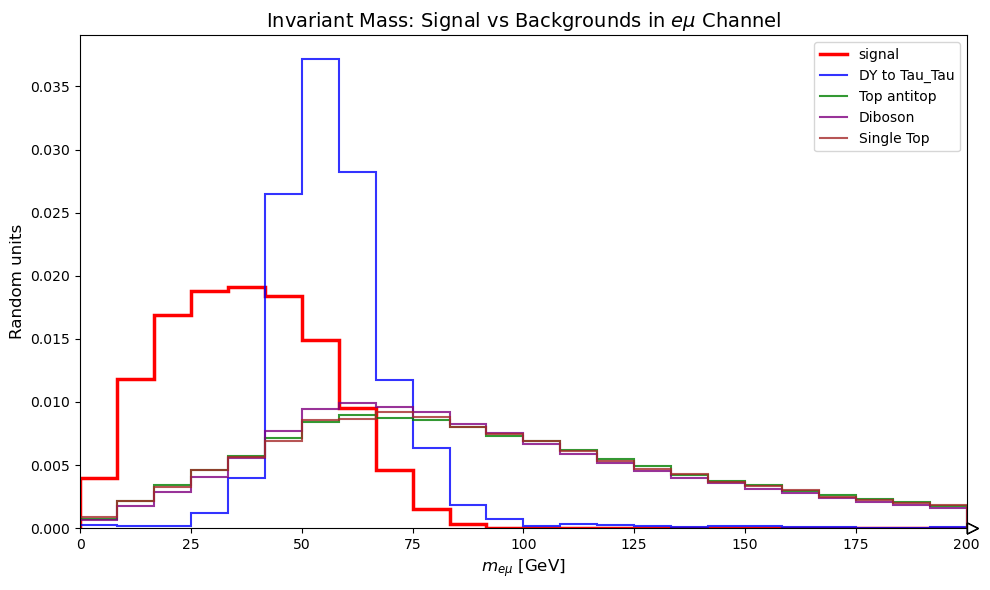

In [21]:
# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 6))

for label in files.keys():
    if event_variables[label] is not None:
        masses = event_variables[label]['mass']
        masses_np = ak.to_numpy(masses)
        # hist, _ = np.histogram(masses_np, bins=mass_bins, density=True)
        # bin_centers = (mass_bins[:-1] + mass_bins[1:]) / 2
        
        h = Hist.new.Var(mass_bins, name="masses").Double()        
        h.fill(masses=masses_np)

        linewidth = 2.5 if label == 'signal' else 1.5
        alpha = 1.0 if label == 'signal' else 0.8
        
        # plt.step(bin_centers, hist, where="mid", 
        #          label=label, color=colors[label], 
        #          linewidth=linewidth, alpha=alpha)

        h.plot(ax=ax, histtype="step", label=label, color=colors[label],
               linewidth=linewidth, alpha=alpha,density =True,yerr=False)
        
ax.set_xlabel(r"$m_{e\mu}$ [GeV]", fontsize=12)
ax.set_ylabel("Random units", fontsize=12)
ax.set_title("Invariant Mass: Signal vs Backgrounds in $e\\mu$ Channel", fontsize=14)
ax.legend()
ax.grid(False)
ax.set_xlim(0, 200)
plt.tight_layout()
plt.show()

### Leading and Subleading Lepton Kinematic Distributions

Create 2 × 3 subplots to visualize the kinematics of leading and subleading leptons:

1. **Define binning** for transverse momentum ($p_T$), pseudorapidity ($\eta$), and azimuthal angle ($\phi$).  
2. **Loop over lepton types** (`leading` and `subleading`) and kinematic variables (`pt`, `eta`, `phi`).  
3. **For each dataset** (signal and backgrounds):  
   - Extract the corresponding lepton collection from `event_variables`  
   - Retrieve the variable of interest  
   - Fill a histogram using `Hist` and convert to NumPy if necessary  
   - Plot as a step plot with dataset-specific color, line width, and transparency  
4. **Axis formatting**:  
   - Set X-axis labels and limits according to variable type  
   - Y-axis normalized to unity  
   - Light grid lines for readability  
   - Legends with small font to fit in subplots  
5. **Overall figure title**: "Leading and Subleading Lepton Distributions in $e\mu$ Events"  
6. **Layout adjustment** and display the figure.


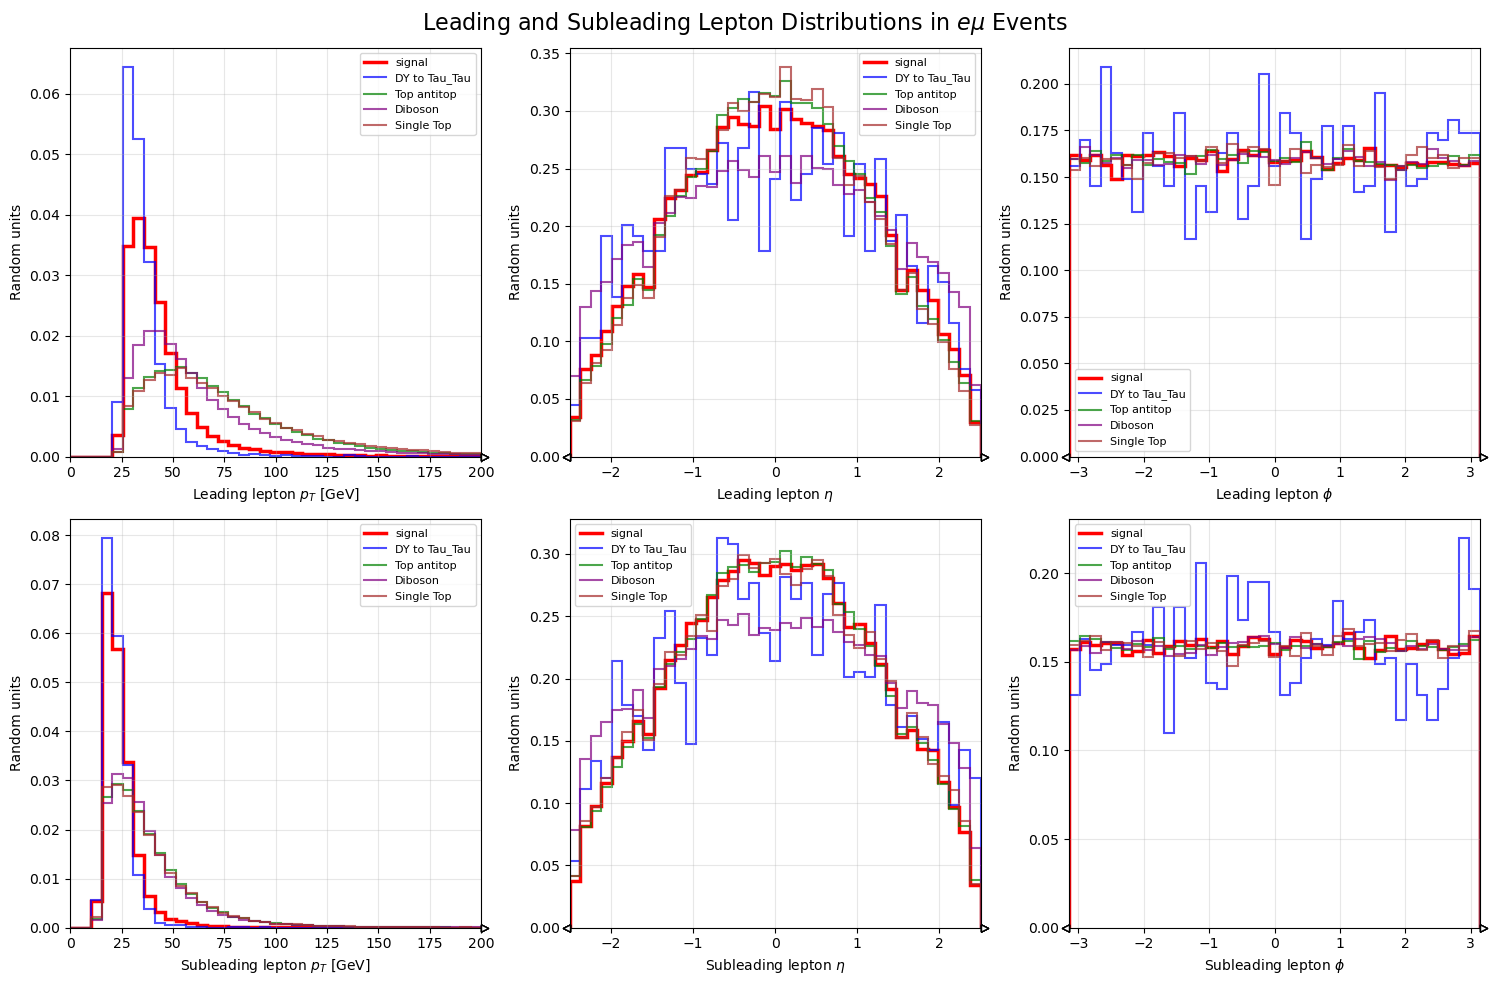

In [27]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Define binning
pt_bins = np.linspace(0, 200, 40)
eta_bins = np.linspace(-2.5, 2.5, 40)
phi_bins = np.linspace(-np.pi, np.pi, 40)
bins_dict = {
    'pt': pt_bins,
    'eta': eta_bins,
    'phi': phi_bins
}

# Plot for each kinematic variable
variables = ['pt', 'eta', 'phi']
leptons = ['leading', 'subleading']

for i, lep_type in enumerate(leptons):
    for j, var in enumerate(variables):
        ax = axes[i, j]
       
        # Plot each sample
        for label in files.keys():
            if label in event_variables and event_variables[label] is not None:
                # Get the appropriate lepton collection
                if lep_type == 'leading':
                    lepton_data = event_variables[label]['leading']
                else:  # subleading
                    lepton_data = event_variables[label]['subleading']
               
                # Get the variable data
                data = getattr(lepton_data, var)
               
                if len(data) > 0:
                    data_np = ak.to_numpy(data)
                   
                    # Create histogram using hist library
                    h = Hist.new.Var(bins_dict[var], name=var).Double()
                    h.fill(**{var: data_np})
                   
                    # Plot
                    linewidth = 2.5 if label == 'signal' else 1.5
                    alpha = 1.0 if label == 'signal' else 0.7
                    h.plot(ax=ax, histtype="step", label=label, color=colors[label],
                           linewidth=linewidth, alpha=alpha, density=True,yerr=False)
       
        # Formatting
        if var == 'pt':
            ax.set_xlabel(f'{lep_type.capitalize()} lepton $p_T$ [GeV]')
            ax.set_xlim(0, 200)
        elif var == 'eta':
            ax.set_xlabel(f'{lep_type.capitalize()} lepton $\\eta$')
            ax.set_xlim(-2.5, 2.5)
        else:
            ax.set_xlabel(f'{lep_type.capitalize()} lepton $\\phi$')
            ax.set_xlim(-np.pi, np.pi)
           
        ax.set_ylabel('Random units')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.suptitle('Leading and Subleading Lepton Distributions in $e\\mu$ Events', fontsize=16)
plt.tight_layout()
plt.show()

### Event-Level Kinematic Distributions

Visualize key event-level variables for $e\mu$ events in a 2 × 2 grid:

1. **Define variables**:  
   - Missing transverse energy ($E_T^{miss}$)  
   - Azimuthal angle difference between leptons ($\Delta\phi_{e\mu}$)  
   - Transverse momentum of the dilepton system ($p_T^{e\mu}$)  
   - Invariant mass of the dilepton system ($m_{e\mu}$)  

2. **Loop over variables and datasets**:  
   - Extract the variable data from `event_variables`  
   - Fill a histogram using `Hist` and convert awkward arrays to NumPy  
   - Plot as a step histogram with dataset-specific color, line width, and transparency  

3. **Axis formatting**:  
   - X-axis label and limits defined per variable  
   - Y-axis normalized to unity  
   - Light grid lines for readability  
   - Legend included with small font  

4. **Figure title**: "Event-Level Distributions in $e\mu$ Channel"  
5. **Layout adjustment** and display the figure.


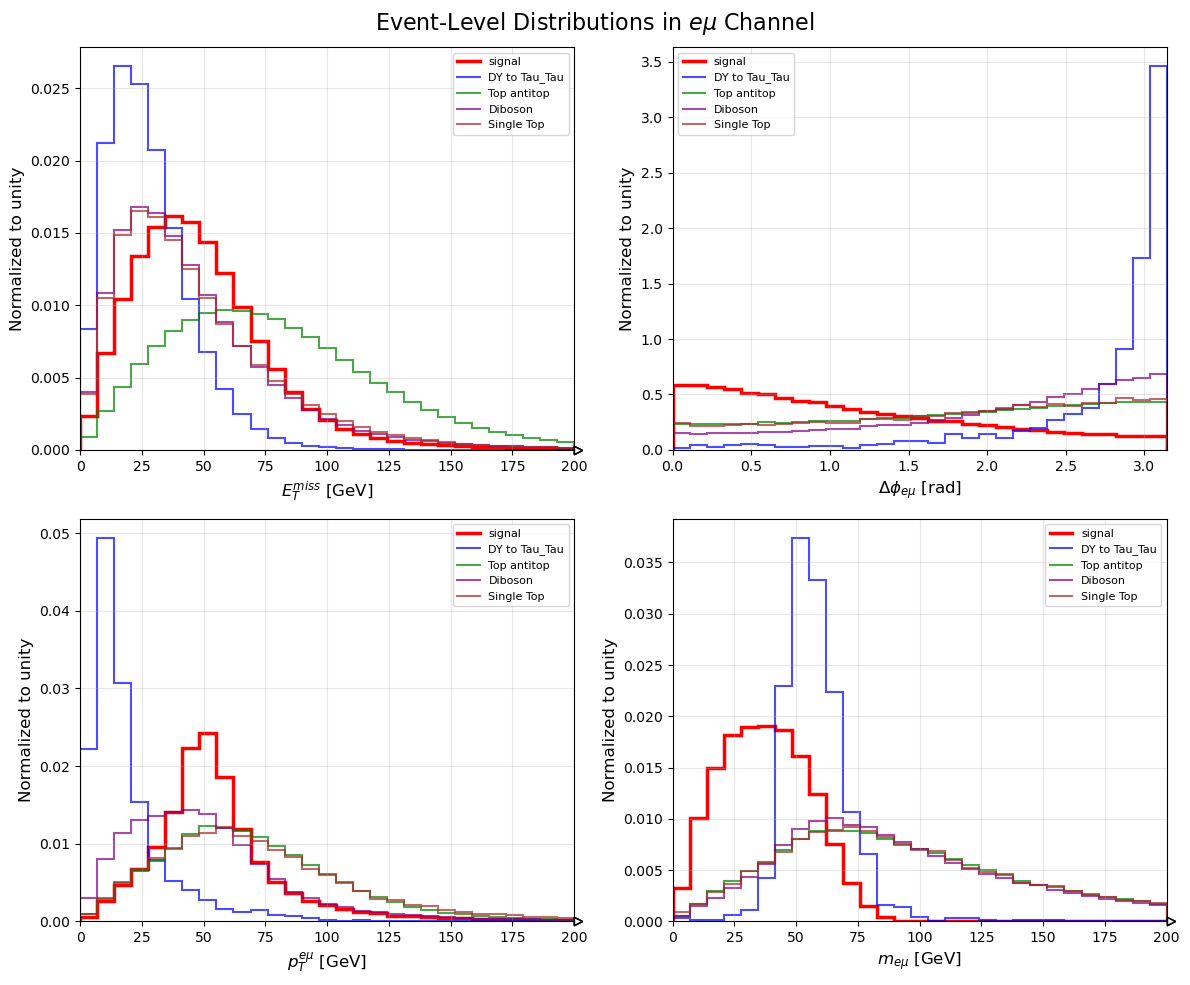

In [23]:


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

event_vars = {
    'met': {
        'bins': np.linspace(0, 200, 30),
        'xlabel': '$E_T^{miss}$ [GeV]',
        'xlim': (0, 200)
    },
    'dphi': {
        'bins': np.linspace(0, np.pi, 30),
        'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]',
        'xlim': (0, np.pi)
    },
    'ptll': {
        'bins': np.linspace(0, 200, 30),
        'xlabel': '$p_T^{e\\mu}$ [GeV]',
        'xlim': (0, 200)
    },
    'mass': {
        'bins': np.linspace(0, 200, 30),
        'xlabel': '$m_{e\\mu}$ [GeV]',
        'xlim': (0, 200)
    }
}

for idx, (var_name, var_props) in enumerate(event_vars.items()):
    ax = axes[idx]
   
    for sample in files.keys():
        if event_variables[sample] is not None and var_name in event_variables[sample]:
            data = event_variables[sample][var_name]
            data_np = ak.to_numpy(data)
           
            if len(data_np) > 0:
                # Create histogram using hist library
                h = Hist.new.Var(var_props['bins'], name=var_name).Double()
                h.fill(**{var_name: data_np})
               
                # Plot
                linewidth = 2.5 if sample == 'signal' else 1.5
                alpha = 1.0 if sample == 'signal' else 0.7
                h.plot(ax=ax, histtype="step", label=sample, color=colors[sample],
                       linewidth=linewidth, alpha=alpha, density=True, yerr=False)
   
    ax.set_xlabel(var_props['xlabel'], fontsize=12)
    ax.set_ylabel('Normalized to unity', fontsize=12)
    ax.set_xlim(var_props['xlim'])
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Event-Level Distributions in $e\\mu$ Channel', fontsize=16)
plt.tight_layout()
plt.show()

### Summary Statistics of Selected Events

After applying the $e\mu$ selection, we can quickly summarize each dataset with a few key statistics:

- **Number of events:** total events that survive the selection  
- **Mean invariant mass ($m_{e\mu}$):** average mass of the eμ system  
- **Mean missing transverse energy (MET):** average MET from neutrinos  
- **Mean azimuthal separation ($\Delta\phi_{\ell\ell}$):** average angular separation between the electron and muon  
- **Mean dilepton transverse momentum ($p_T^{\ell\ell}$):** average transverse momentum of the eμ system  

These statistics provide a **quick sanity check** and make it easy to compare the **signal** and **background** distributions at a glance, helping us spot any unexpected behavior before moving on to deeper analysis.


In [24]:
print("\n=== Summary Statistics ===\n")
for label in files.keys():
    if event_variables[label] is not None:
        print(f"{label}:")
        print(f"  Number of events: {len(event_variables[label]['mass'])}")
        print(f"  Mean mass: {np.mean(ak.to_numpy(event_variables[label]['mass'])):.2f} GeV")
        print(f"  Mean MET: {np.mean(ak.to_numpy(event_variables[label]['met'])):.2f} GeV")
        print(f"  Mean dphi: {np.mean(ak.to_numpy(event_variables[label]['dphi'])):.3f} rad")
        print(f"  Mean ptll: {np.mean(ak.to_numpy(event_variables[label]['ptll'])):.2f} GeV")
        print()


=== Summary Statistics ===

signal:
  Number of events: 83154
  Mean mass: 37.59 GeV
  Mean MET: 49.96 GeV
  Mean dphi: 1.135 rad
  Mean ptll: 57.24 GeV

DY to Tau_Tau:
  Number of events: 1752
  Mean mass: 58.02 GeV
  Mean MET: 28.10 GeV
  Mean dphi: 2.721 rad
  Mean ptll: 20.04 GeV

Top antitop:
  Number of events: 178544
  Mean mass: 110.46 GeV
  Mean MET: 81.81 GeV
  Mean dphi: 1.769 rad
  Mean ptll: 70.41 GeV

Diboson:
  Number of events: 114231
  Mean mass: 110.98 GeV
  Mean MET: 48.18 GeV
  Mean dphi: 2.035 rad
  Mean ptll: 54.04 GeV

Single Top:
  Number of events: 30948
  Mean mass: 111.35 GeV
  Mean MET: 48.81 GeV
  Mean dphi: 1.802 rad
  Mean ptll: 74.51 GeV



### Stacked Histogram for Event-Level Variables

This function creates a stacked histogram combining all datasets:

1. **Order of stacking**:  
   - Backgrounds first: Drell–Yan, Top–antitop, Diboson, Single Top, W+jets  
   - Signal on top  

2. **Collect data** for each sample from `var_data` for the specified `variable_name`.  
   - Convert awkward arrays to NumPy  
   - Skip empty datasets with warnings  

3. **Plot stacked histogram**:  
   - Use dataset-specific colors  
   - Semi-transparent (`alpha=0.8`) with black edges  
   - X-axis: variable name (from `var_props['xlabel']`)  
   - Y-axis: number of events, log scale enabled with minimum 0.1 to avoid log(0)  

4. **Add legend, title, and formatting**:  
   - Legend in upper right  
   - Grid disabled for clarity  
   - Layout adjusted with `tight_layout`  

This provides a clear visualization of signal and background contributions to a given event-level variable.


In [25]:
def create_stacked_plot(variable_name, var_data, var_props, colors):
    """Create stacked histogram with all samples stacked together"""
   
    fig, ax = plt.subplots(figsize=(10, 6))
   
  # Define order: backgrounds first, then signal on top
    backgrounds = ['DY to Tau_Tau', 'Top antitop', 'Diboson', 'Single Top', 'Wjets']
    signal = ['signal']

# Combine all samples in the order we want them stacked
    all_samples = backgrounds + signal  
   
    # Collect data for all samples
    all_data = []
    all_labels = []
    all_colors = []
   
    for sample in all_samples:
        if sample in var_data and var_data[sample] is not None:
            if variable_name in var_data[sample]:
                data = ak.to_numpy(var_data[sample][variable_name])
                if len(data) > 0:
                    all_data.append(data)
                    all_labels.append(sample)
                    all_colors.append(colors[sample])

   
    # Create the stacked histogram
    if all_data:
        n, bins, patches = ax.hist(all_data, bins=var_props['bins'],
                                   label=all_labels, color=all_colors,
                                   stacked=True, alpha=0.8, 
                                   edgecolor='black', linewidth=0.5)

   
    ax.set_xlabel(var_props['xlabel'], fontsize=12)
    ax.set_ylabel('Events', fontsize=12)
    ax.set_xlim(var_props['xlim'])
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(False)
   
    plt.title(f'Stacked {variable_name.capitalize()} Distribution', fontsize=14)
    
    # Use logarithmic scale if data spans several orders of magnitude
    if all(len(d) > 0 for d in all_data):
        plt.yscale('log')
        # Set y-axis lower limit to avoid log(0)
        ax.set_ylim(bottom=0.1)
    
    plt.tight_layout()
    plt.show()

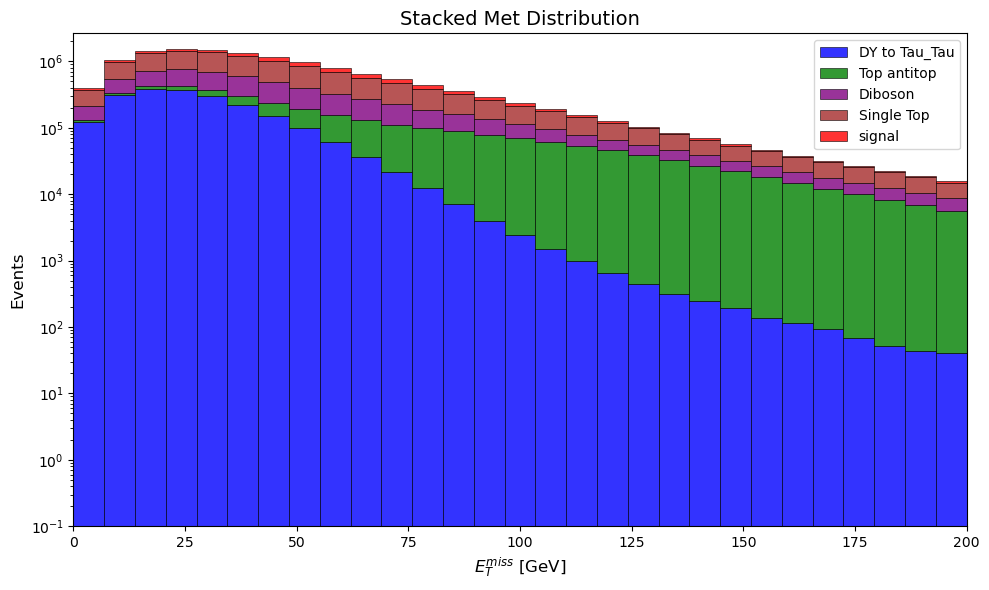

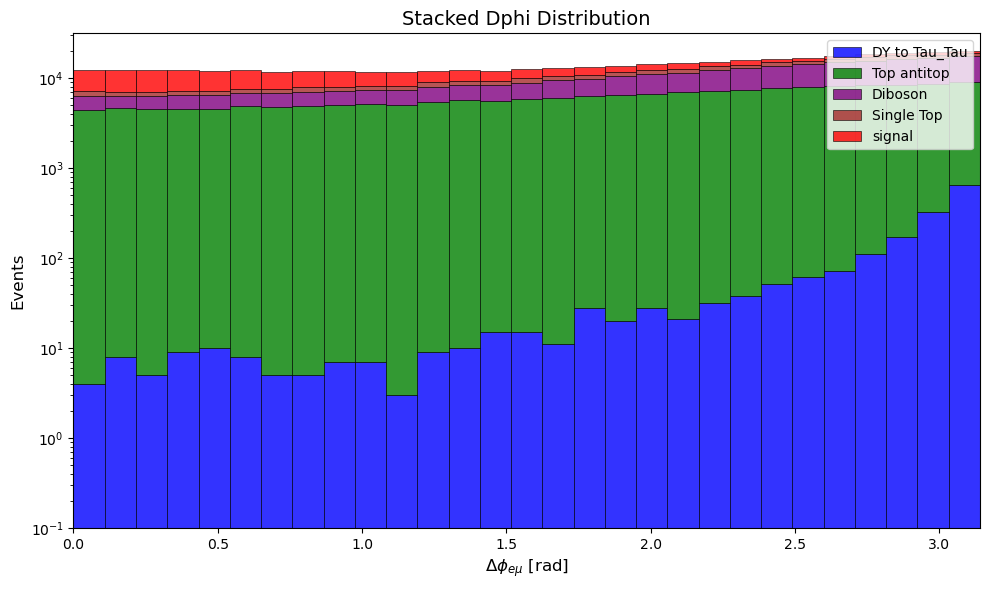

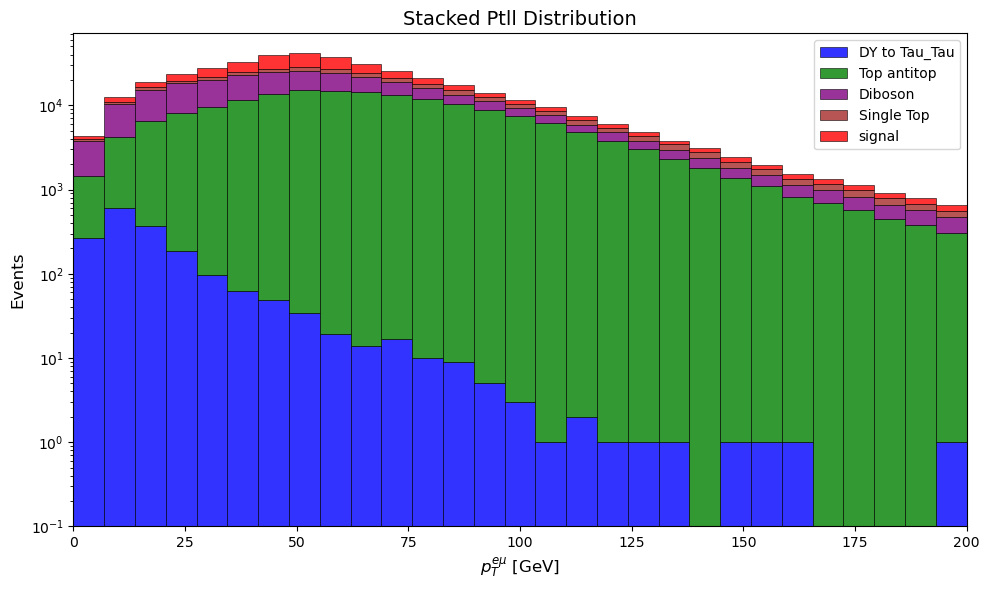

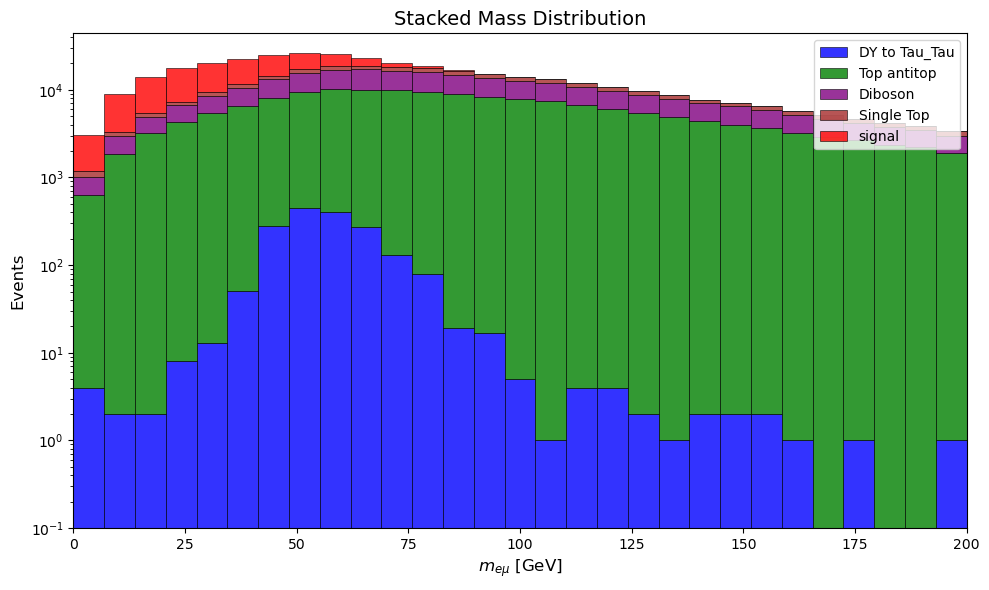

In [26]:
# Create stacked plots for all event variables
for var_name, var_props in event_vars.items():
    create_stacked_plot(var_name, event_variables, var_props, colors)

